# Data visualization
1.   Plot the data in various ways.
2.   Use the plots to identify outliers, bad data, etc
3.   Use the plots to identify patterns and relations in the data
4.   Repeat the process as necessary to get a clear view of what is going on

-What causes two people to be friends
  -Explore the relationship between similarity and friendship

-Predict User retention
  -Run linear regression and find imp coeffs

In [0]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import stats
from google.colab import drive
from IPython.display import clear_output
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# The file directories
folder = '/content/drive/My Drive/Hallo_Data/'
clean_folder = folder + 'clean_data/'
feat_folder = folder + 'features_added/'

In [0]:
def get_sample(friend_df, user_df, n=1500):
    """Graphs are too complex when every user is included. This
    function attempts at creating a random, representative sample of 
    the population of data.
    
    Returns (Dataframe, Dataframe) - friend_sample_df, users_sample_df"""
    #shell of friend dataframe that will capture relavent connections to user sample
    friend_sample_df = pd.DataFrame([], columns = friend_df.columns) 

    non_streamer_df = user_df[user_df["streamer"] == False]
    streamer_df = user_df[user_df["streamer"] == True]
    #draw random sample from user base
    non_streamer_sample_df = non_streamer_df.sample(n=n)
    
    #id's of sampled users
    user_sample_ids = set()
    #include all streamers since their existence is integral to any sort of analysis
    # user_sample_ids.update(streamer_df.index)
    user_sample_ids.update(non_streamer_sample_df.index)

    #ids of people connected to user sample
    user_connected_ids = set()

    #next, get all the relationships associated with the user sample
    for user_id in user_sample_ids:
        #get all bi-directional connections associated with given user
        user_connections_df = friend_df[(friend_df["user_id"] == user_id) | (friend_df["friend_id"] == user_id)]
        #keep track friends of given user to user sample so they can be graphed/analyzed later
        user_connected_ids.update(user_connections_df
                                  .values
                                  .flatten())
        
        friend_sample_df = pd.concat([friend_sample_df, user_connections_df], ignore_index=True)

    #get rid of duplicate columns from friend connection sample
    #which come from a user in the sample who is a friend of another
    #in the sample causing the connection to be added twice
    friend_sample_df.drop_duplicates().reset_index(drop=True)

    #add user friends to sample
    # user_sample_ids.update(streamer_df.index)
    user_sample_ids.update(user_connected_ids)
    #create user sample df from user sample id's
    user_sample_df = user_df.loc[user_sample_ids, :]

    return friend_sample_df, user_sample_df
    

In [0]:
friend_df = pd.read_pickle(f"{clean_folder}friends_table_clean.pkl")
user_df = pd.read_pickle(f"{feat_folder}users.pkl")

friend_sample_df = pd.read_pickle(f"{feat_folder}friend_sample_0.pkl")
user_sample_df = pd.read_pickle(f"{feat_folder}user_sample_average_sim.pkl")

print(friend_sample_df.keys())
print(user_sample_df.keys())
print(sum(friend_sample_df["friendship_strength"]))

# print(sum(friend_sample_df["common_friends_count"]))

Index(['user_id', 'friend_id', 'similarity', 'friendship_strength',
       'common_friends_count', 'message_count0', 'message_count1',
       'message_count2', 'message_count3', 'message_count4', 'message_count5',
       'message_count6', 'message_count7', 'message_count8', 'message_count9',
       'message_count'],
      dtype='object')
Index(['last_status_update', 'native_country', 'native_lang', 'points',
       'streamer', 'follower_count', 'admin', 'coin_balance', 'last_online',
       'english_proficiency', 'banned', 'hop_on_rate',
       'livestream_push_notify', 'suspended', 'push_notify', 'level',
       'num_friends', 'similarity', 'friendship_strength',
       'common_friends_count', 'num_followed', 'user_activity',
       'average_similarity_population', 'average_similarity_friends'],
      dtype='object')
2900.949999999999


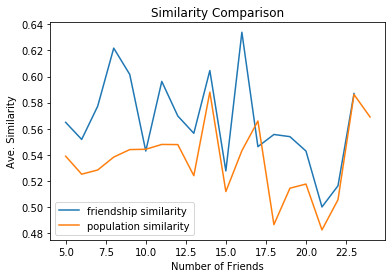

In [0]:
population_similarity = []
friendship_similarity = []

#friend range
num_friend_domain = range(2, 25)

#get average similarity levels corresponding to each # of friends
for i in num_friend_domain:

  population_similarity.append(
      #get average pop. similarity for everyone with i friends
      user_sample_df[user_sample_df["num_friends"] == i]["average_similarity_population"].mean()
  )
  friendship_similarity.append(
      #get average friend similarity for everyone with i friends
      user_sample_df[user_sample_df["num_friends"] == i]["average_similarity_friends"].mean()
  )

#graph results
plt.plot(num_friend_domain, friendship_similarity, label="friendship similarity")
plt.plot(num_friend_domain, population_similarity, label="population similarity")
plt.title("Similarity Comparison")
plt.xlabel("Number of Friends")
plt.ylabel("Ave. Similarity")
plt.legend()
plt.show()

One of our original goals in the proposal was, given two users, figure out the liklihood that they would become friends upon an initial interaction. We assumed that friends would naturally be similar in some respect. We then developed a similarity metric, which as shown above, is not perfect but justified nonetheless. Friendship similairty is cearly stronger than that of any random user of the population regardless of the amount of friends a user has. Specifically, friends tend to have similar cultures, language proficiency levels, and interest in certain teachers.

>


It should be expected that the gap between the two curves be initially small since the app is new and their are many potential friendships to be exploited. In other words, the potential friendships, which are many, bring up the population similarity.




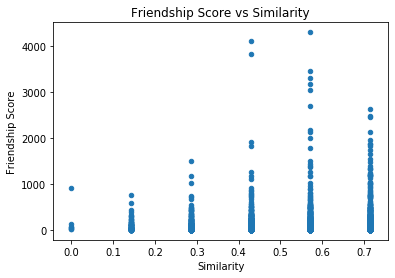

In [0]:
# friendship_strength = []

# #friend range
# ranges = [[0, .25], [.25, .5], [.5, .75], [.75, 1]]

# #get average similarity levels corresponding to each # of friends
# for a, b in ranges:
#   mask = (friend_sample_df["friendship_strength"] > a) & (friend_sample_df["friendship_strength"] <= b)
#   friendship_strength.append(
#       #get average pop. similarity for everyone with i friends
#       friend_sample_df[mask]["similarity"].mean()
#   )

# #graph results
# plt.plot([0, .25, .5, .75], friendship_strength, label="friendship strength")
# plt.title("Similarity Comparison")
# plt.xlabel("Number of Friends")
# plt.ylabel("Ave. Friendship Strength")
# plt.legend()
# plt.show()

friend_sample_df[(friend_sample_df["message_count"]  > 0 ) & (friend_sample_df["message_count"]  < 5000)].plot(kind="scatter", y="message_count", x="similarity")
plt.title("Friendship Score vs Similarity")
plt.ylabel("Friendship Score")
plt.xlabel("Similarity")
plt.title("Friendship Score vs Similarity")
plt.show()
# friend_sample_df.plot(kind="hist", y="friendship_strength")
# plt.show()


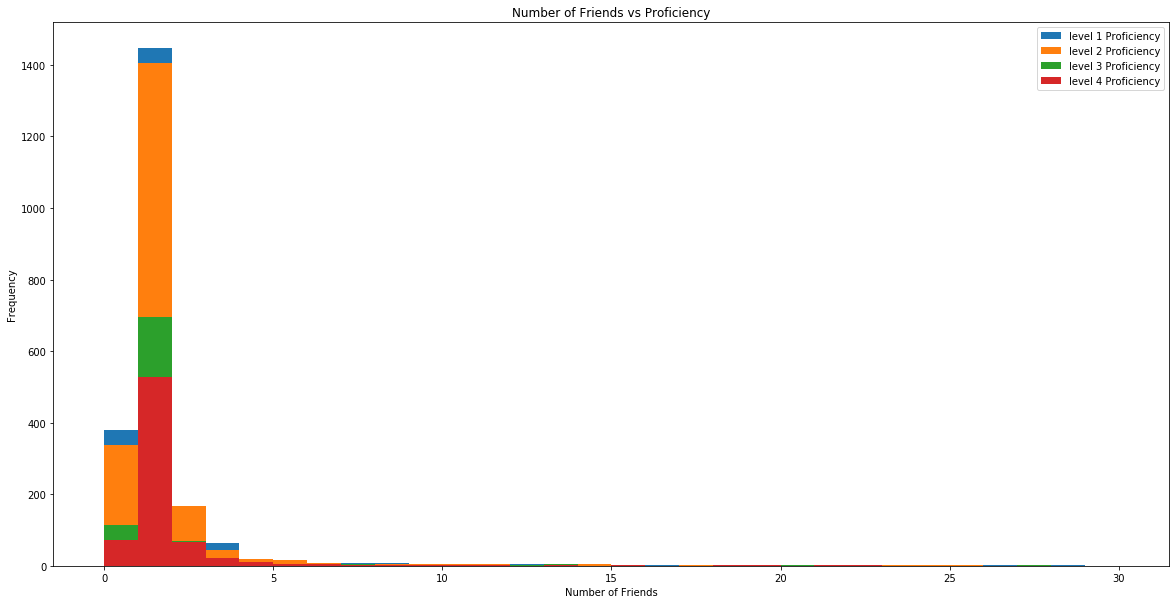

In [0]:
user_df = user_df[user_df["num_friends"] < 30]

l1_user_friends = user_df[user_df["english_proficiency"] == 1]["num_friends"].values #plot(kind='kde', x = np.linspace(0, 30, 100))
l2_user_friends = user_df[user_df["english_proficiency"] == 2]["num_friends"].values
l3_user_friends = user_df[user_df["english_proficiency"] == 3]["num_friends"].values
l4_user_friends = user_df[user_df["english_proficiency"] == 4]["num_friends"].values


plt.figure(figsize=(20,10))
plt.hist(l1_user_friends, np.linspace(0, 30, 31), label="level 1 Proficiency")
plt.hist(l2_user_friends, np.linspace(0, 30, 31), label="level 2 Proficiency")
plt.hist(l3_user_friends, np.linspace(0, 30, 31), label="level 3 Proficiency")
plt.hist(l4_user_friends, np.linspace(0, 30, 31), label="level 4 Proficiency")

plt.xlabel("Number of Friends")
plt.ylabel("Frequency")
plt.title("Number of Friends vs Proficiency")
plt.legend()
plt.show()

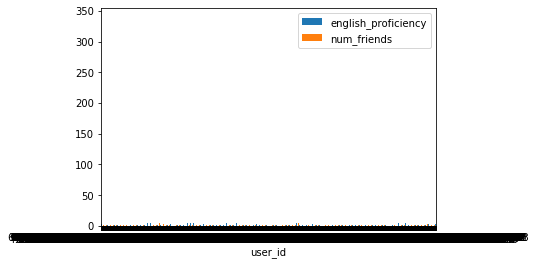

In [0]:
#friends vs english prof
num_friends = []
types_users = []

D = range(1, 6)
#get average similarity levels corresponding to each # of friends
for i in D:
  mask = user_sample_df["english_proficiency"] == i
  types_users.append(sum(mask))
  num_friends.append(
      #get average amount of friends for people with lang. prof. i
      user_sample_df[mask]["num_friends"].mean()
  )

#####plot percentages of users in each area as well
# user_sample_df.plot.hexbin(x='english_proficiency', y='num_friends', gridsize=30)

user_df[["english_proficiency", "num_friends"]].plot.bar(rot=0)
#graph results
# fig, = plt.fig(2)
# plt.plot(D, num_friends)
# plt.title("Friend Count vs Language Prof.")
# plt.xlabel("Language Proficiency")
# plt.ylabel("Ave. Number of Friends")
# plt.legend()
# plt.show()

In [0]:
friend_df = pd.read_pickle(f"{clean_folder}friends_table_clean.pkl")
user_df = pd.read_pickle(f"{clean_folder}users_clean.pkl")
friend_sample_df, user_sample_df = get_sample(friend_df, user_df, n=1500)

friend_sample_df.to_pickle(clean_folder+"friend_sample_0.pkl")
user_sample_df.to_pickle(clean_folder+"user_sample_0.pkl")
print("done")

done


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [0]:
print(friend_sample_df)

                            user_id  ... common_friends_count
0      gP7ZHMg1WIZvllpAa37lqlCJ8tc2  ...                    0
1      gP7ZHMg1WIZvllpAa37lqlCJ8tc2  ...                    0
2      7U8yWsGQkIW2s6vwrqXsNp5rvSH3  ...                    0
3      rj0DImyvv9Zc8wGaxrWExI8fBxu2  ...                    0
4      CWTjlbro3SZUIoxsdzBiHgnXopp1  ...                    0
...                             ...  ...                  ...
10556  BPfUYdvtFUQlLsU1tYMTVBwcRDK2  ...                    0
10557  BPfUYdvtFUQlLsU1tYMTVBwcRDK2  ...                    0
10558  YzrqpW8f7TgHfPj08qXGx0ia3eh1  ...                    0
10559  YzrqpW8f7TgHfPj08qXGx0ia3eh1  ...                    0
10560  9ldo7azuzCasx58oBiLQjWNKGO92  ...                    0

[10561 rows x 5 columns]


In [0]:
#english proficiency and number of friends


In [0]:
def merge_friends_shiz():
    dfs = [pd.read_pickle(clean_folder+f"messages/messages-{i}.pkl") for i in range(2)]
    friend_df = pd.read_pickle(folder+"features_added/friend_sample_0.pkl")
    friend_df["message_count"] = 0
    for idx in friend_df.index:
        user_id, friend_id = friend_df.loc[idx, ["user_id", "friend_id"]]
        message_count = 0
        for df in dfs:
            mask = (df.conversation.str.contains(f'{user_id}')) & (df.conversation.str.contains(f'{friend_id}'))
            message_count += len(df[mask])
        friend_df.loc[mask, "message_count"] = message_count
        print(message_count)
        break
        
    # friend_df.to_pickle("Hallo_Data/features_added/friends_table_msgs.pkl")

    return friend_df


In [0]:
friend_df = merge_friends_shiz()


8


AttributeError: ignored

In [0]:
friend_df['message_count'].values_counts()

AttributeError: ignored

In [0]:
#give streamers the color red and the rest black
user_sample_df["color"] = "black"
user_sample_df.loc[(user_sample_df["streamer"] == True), "color"] = "red"

#make streamer nodes bigger
user_sample_df["size"] = 1
user_sample_df.loc[(user_sample_df["streamer"] == True), "size"] = 20


G = nx.DiGraph()
# G = nx.Graph()
G.add_nodes_from(user_sample_df.index)
G.add_edges_from(friend_sample_df[["user_id", "friend_id"]].values)

plt.figure(1, figsize=(50,50))
nx.draw_spring(G, node_size=user_sample_df["size"].values, node_color=user_sample_df["color"].values, edge_color="blue")

plt.show() 


Output hidden; open in https://colab.research.google.com to view.

In this graph, we notice that there exist a handful of users that hold most of the connections within the network. These are the blue clusters that spread like a fan. Note that the primary users of the strucure, seen at the tip, has many friends who have only have her/him as a friend. Since friends tend to be similar, it is likely that these little fan like clusters can be grown into mini interconnected communities. Intuitively, we should focus on expanding these communities first. After those are expanded, we can intertwine other mini communities that are connected.

In [0]:
plt.figure(1, figsize=(50,50))
nx.draw_circular(G, node_size=user_sample_df["size"].values, node_color=user_sample_df["color"].values, edge_color="blue")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
friend_df = pd.read_pickle(f"{feat_folder}friend_sample_0.pkl")
user_df = pd.read_pickle(f"{feat_folder}user_sample_0.pkl")
print(len(user_df))

friend_df.head(10)
print(np.argmax(user_df["num_friends"].values))
print(max(user_df["num_friends"].values))
print(user_df.iloc[1730])

6260
1730
337.0
last_status_update        2019-08-13 03:32:10.835000+00:00
native_country                                    Pakistan
native_lang                                         Pashto
points                                                   0
streamer                                             False
follower_count                                           0
admin                                                False
coin_balance                                             0
last_online               2019-11-03 19:34:50.409000+00:00
english_proficiency                                      2
banned                                               False
hop_on_rate                                              0
livestream_push_notify                               False
suspended                                            False
push_notify                                           True
level                                                    0
num_friends                             